In [2]:
try:
    # mount google drive
    from google.colab import drive  # nopep8
    drive_path = "/content/drive"
    drive.mount(drive_path)
    drive_folder = drive_path + "/MyDrive/dtm/"
    using_colab = True
except ModuleNotFoundError:
    # Assume we are not on google colab,
    drive_folder = "data/"
    using_colab = False
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Params and Init

In [28]:
!pip -qq install --upgrade pip
!pip -qq install plyfile deepdiff talos GitPython
!pip -qq install --upgrade imgaug
import talos
from deepdiff import DeepDiff
import re
import numpy as np
from progressbar import progressbar, ProgressBar
import sys
import os
import cv2
import math
import json
import importlib
import matplotlib.pyplot as plt
import tensorflow as tf
import git
import keras
import keras.backend as K
import datetime
import imgaug.augmenters as iaa
cuda_paths=!ls /usr/local | grep cuda-
os.environ['CUDA_HOME'] = os.path.join("/usr/local/",cuda_paths[-1])

In [45]:
if using_colab:
    !git -C /content/deep_ga/ pull || git clone https://github.com/InigoMoreno/deep_ga
    sys.path.append('/content/deep_ga')
    import deep_ga  # nopep8
    deep_ga=importlib.reload(deep_ga)
else:
    MODULE_PATH = "deep_ga/deep_ga/__init__.py"
    MODULE_NAME = "deep_ga"
    git.cmd.Git(MODULE_NAME).pull()
    spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
    deep_ga = importlib.util.module_from_spec(spec)
    sys.modules[spec.name] = deep_ga
    spec.loader.exec_module(deep_ga)


Already up to date.


In [23]:
p={
  "resolution" : 1,                      # resolution of map [meters per pixel]
  "mapLength"  : 100,                    # size of one side of the map [meters]
  "minSlopeThreshold"  : 0.5,            # minimum slope to be counted [proportion]
  "maxNanPercentage"   : 5/100,           # maximum percentage of NaNs in a patch [%]
  "minSlopePercentage" : 10/100,          # minimum percentage of slope in a patch [%]
  "maxSlopePercentage" : 40/100,          # maximum percentage of slope in a patch [%]
  "stdPatchShift"          : 15,          # standard deviation of shift between to patches [m]
   "raycastHeight": 2,
   "booleanDist": False
}
p["mapLengthPixels"]=math.ceil(p["mapLength"]/p["resolution"])

p["augment_a"] = iaa.Sequential([
    # iaa.PerspectiveTransform(scale=0.02),
    iaa.BlendAlphaSimplexNoise(iaa.Add(0.2), upscale_method="cubic", size_px_max=4),
])

hyperparams = {
    "input": ["raw", "rawmask", "sobel", "fixsobel", "PConv", "SymConv", "Conv"],
    # "batch_size": [32, 64, 128, 256],
    "batch_size": [32],
    # "mobileNet_alpha": [0.25, 0.5, 1],
    "mobileNet_alpha": [1],
    # "mobileNet_pooling": ["avg", "max", None],
    "mobileNet_pooling": ["avg"],
    # "firstLayerSize": [4096, 1280, 1000],
    "firstLayerSize": [1000],
    # "secondLayerSize": [1000, 500, 100],
    "secondLayerSize": [500],
    # "activation": ["relu", None],
    "activation": ["relu"],
    # "dropout": [0, 0.2, 0.5],
    "dropout": [0.2],
    # "sharedWeights": [True, False],
    "sharedWeights": [True],
    # "loss": ["MSE", "MAE", "DOOMSE", "PCL", "BCE"],
    "loss": ["MSE"],
    # "los_scale": [2, 5, 10],
    "los_scale": [1],
    # "learning_rate": [0.01, 0.001, 0.0001],
    "learning_rate": [0.0001],
    # "learnEnding": [True, False]
    "learnEnding": [False]
}

first_hyperparams={k:v[0] for k,v in hyperparams.items()}

# Dataset preparation

In [6]:
!pip -q install gdal wget
import gdal, wget, os

filename="oxia_planum.IMG"

filename=os.path.join(drive_folder, "oxia_planum.IMG")

#get file if it does not exist
#from https://www.uahirise.org/dtm/dtm.php?ID=ESP_037070_1985
url = "https://www.uahirise.org/PDS/DTM/ESP/ORB_037000_037099/ESP_037070_1985_ESP_037136_1985/DTEEC_037070_1985_037136_1985_L01.IMG"
if not os.path.isfile(filename):
  wget.download(url,out = filename)

#transform to numpy array
gdata=gdal.Open(filename)
height=gdata.GetRasterBand(1).ReadAsArray()
height[height<-1e38]=np.nan
height = cv2.resize(height, None, interpolation = cv2.INTER_AREA,
                    fx=gdata.GetGeoTransform()[1] / p["resolution"],
                    fy=-gdata.GetGeoTransform()[5] / p["resolution"])


5.847658143020737


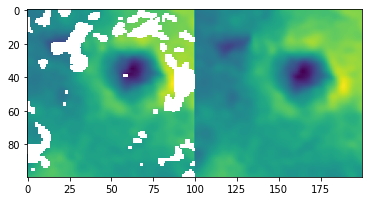

11.753113407524435


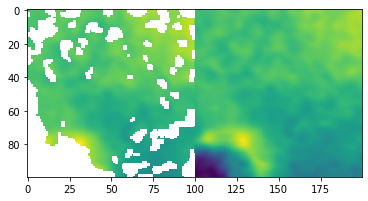

In [7]:
patches_a, patches_b,distances = deep_ga.get_batch(200, height, p)

for i in range(2):
  print(distances[i])
  stack=np.concatenate((patches_a[i,:,:]*50,patches_b[i,:,:]*50),axis=1)
  plt.imshow(stack)
  plt.show()

# Model Preparation

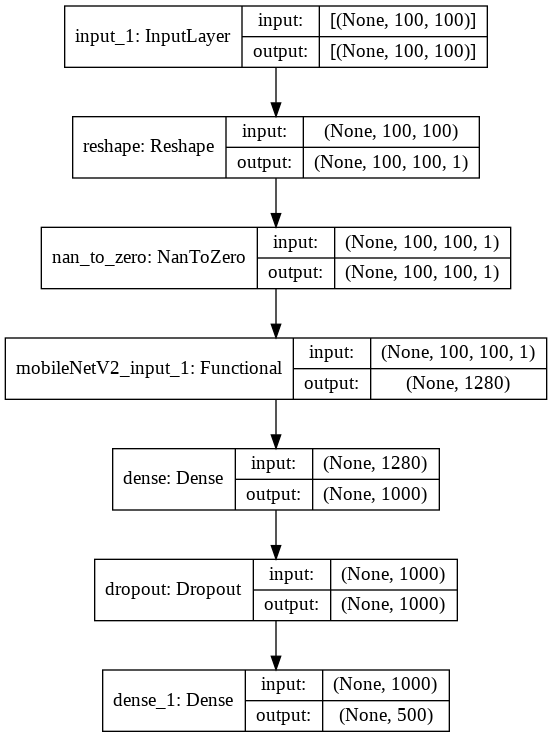

In [24]:
def single_branch(input_tensor, hyperparams=first_hyperparams, suffix=None):
    if suffix is None:
        suffix = "_" + input_tensor.name

    tensor = input_tensor
    tensor = keras.layers.Reshape(
        (input_tensor.shape[1], input_tensor.shape[2], 1))(input_tensor)
    
    #["raw", "rawmask", "sobel", "PConv", "SymConv"]
    if hyperparams["input"] == "raw":
      tensor = deep_ga.NanToZero()(tensor)
    elif hyperparams["input"] == "rawmask":
      raw = deep_ga.NanToZero()(tensor)
      mask = deep_ga.IsNanMask()(tensor)
      tensor = keras.layers.Concatenate()([raw, mask])
    elif hyperparams["input"] == "sobel":
      tensor = deep_ga.SymConv2D(3,True)(tensor)
    elif hyperparams["input"] == "fixsobel":
      tensor = deep_ga.SymConv2D(3,True,trainable=False)(tensor)
    elif hyperparams["input"] == "PConv":
      tensor = deep_ga.PConv2D(3)(tensor)
    elif hyperparams["input"] == "SymConv":
      tensor = deep_ga.SymConv2D(3)(tensor)
    elif hyperparams["input"] == "Conv":
      tensor = deep_ga.NanToZero()(tensor)
      tensor = keras.layers.Conv2D(3,3)(tensor)
    else:
      raise ValueError(f"unknown input {hyperparams['input']}")


    # tensor = keras.applications.mobilenet_v2.preprocess_input(tensor)
    mobileNet = keras.applications.MobileNetV2(
        input_shape=tensor.shape[1:],
        alpha=hyperparams["mobileNet_alpha"],
        include_top=False,
        pooling=hyperparams["mobileNet_pooling"],
        weights=None
    )
    mobileNet._name = "mobileNetV2" + suffix
    for w in mobileNet.weights:
        split_name = w.name.split('/')
        w._handle_name = split_name[0] + suffix + '/' + split_name[1] + suffix
    # for layer in mobileNet.layers:
    #   layer._name += suffix

    # print(mobileNet.summary())
    tensor = mobileNet(tensor)

    tensor = keras.layers.Dense(
        hyperparams["firstLayerSize"], activation=hyperparams["activation"])(tensor)
    tensor = keras.layers.Dropout(hyperparams["dropout"])(tensor)
    tensor = keras.layers.Dense(
        hyperparams["secondLayerSize"], activation=hyperparams["activation"])(tensor)

    return tensor

input = keras.Input(shape=(p["mapLengthPixels"],p["mapLengthPixels"]))

K.clear_session()
first_hyperparams["firstLayer"] ="rawmask"
output = single_branch(input)
model_branch=keras.Model(inputs=[input],outputs=[output])

keras.utils.plot_model(model_branch, show_shapes=True, expand_nested=False)

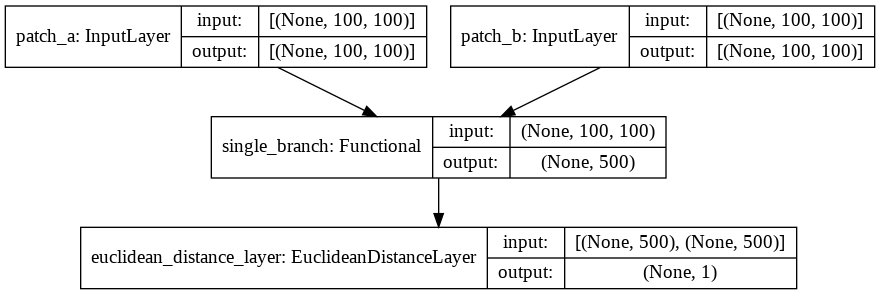

In [9]:

def get_model(hyperparams=first_hyperparams):
    input_a = keras.Input(shape=(
        p["mapLengthPixels"], p["mapLengthPixels"]), name="patch_a")
    input_b = keras.Input(
        shape=(p["mapLengthPixels"], p["mapLengthPixels"]), name="patch_b")

    shared_weights = hyperparams["sharedWeights"]
    if shared_weights:
        input = keras.Input(shape=(p["mapLengthPixels"], p["mapLengthPixels"]))
        branch_model = keras.Model(inputs=[input], outputs=single_branch(
            input, hyperparams, suffix=""), name="single_branch")
        embedding_b = branch_model(input_b)
        embedding_a = branch_model(input_a)
    else:
        embedding_a = single_branch(
            input_a, hyperparams, suffix="-a")
        embedding_b = single_branch(
            input_b, hyperparams, suffix="-b")

    if hyperparams["learnEnding"]:
        embeddings = keras.layers.Concatenate()(
            [embedding_a, embedding_b])
        middle = keras.layers.Dense(500, activation="relu")(embeddings)
        embedding_dist = keras.layers.Dense(1, activation="sigmoid")(middle)
    else:
        embedding_dist = deep_ga.EuclideanDistanceLayer()(
          [embedding_a, embedding_b])

    model = keras.Model(
        inputs=[input_a, input_b], outputs=embedding_dist)
    return model
model=get_model()
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
import scipy.optimize
def compile_model(model, distances, hyperparams=first_hyperparams):
    def normalize(loss):
      def normalize(y_true, y_pred):
        return 100*loss(y_true,y_pred)/normal_loss
      d=K.constant(distances)
      loss_constant= lambda k: loss(K.constant(d),K.constant(np.full_like(d,k))).numpy()
      normal_loss=res=scipy.optimize.minimize_scalar(loss_constant).fun
      normalize.__name__ = 'N{}'.format(loss.__name__)
      return normalize

    def doomloss(sigma):
        def doomloss(y_true, y_pred):
            doom_true = 1 - K.tanh(y_true * 0.80642766 / sigma)
            doom_pred = 1 - K.tanh(y_pred * 0.80642766 / sigma)
            weight = (doom_true + doom_pred) / 2
            return K.mean(weight * K.square(y_true - y_pred))
        return doomloss

    def pairwise_contrastive_loss(margin):
        def pairwise_contrastive_loss(y_true, y_pred):
            mask = K.less(y_true, margin)
            return K.mean(K.switch(mask, K.square(y_pred), K.square(K.maximum(margin - y_pred, 0))))
        return pairwise_contrastive_loss

    
    def binary_cross_entropy(y_true, y_pred):
        y_true/=p["stdPatchShift"]
        y_true=K.clip(y_true,0,1)
        return keras.losses.binary_crossentropy(y_true,y_pred, label_smoothing=0)    

    def true_average(y_true, y_pred):
        return K.mean(y_true)
    def prediction_average(y_true, y_pred):
        return K.mean(y_pred)
    def prediction_std(y_true, y_pred):
        return K.std(y_true)


    losses = {
        "MSE": keras.losses.MSE,
        "MAE": keras.losses.MAE,
        "DOOMSE": doomloss(hyperparams["los_scale"]),
        "PCL": pairwise_contrastive_loss(hyperparams["los_scale"]),
        "BCE": binary_cross_entropy,
    }

    metrics={
        "PAVG": prediction_average,
        "TAVG": true_average,
        "STD": prediction_std,
    }



    for name,loss in losses.items():
      loss.__name__=name
    for name,loss in metrics.items():
      loss.__name__=name
      
    losses={k: normalize(v) for k,v in losses.items()}

    model.compile(
        loss=losses[hyperparams["loss"]],
        metrics=list(losses.values())+list(metrics.values()),
        optimizer=keras.optimizers.Adam(lr=hyperparams["learning_rate"])
    )

    return model

# Model Training

In [11]:

class PrintPrediction(keras.callbacks.Callback):
    def __init__(self):
        super(PrintPrediction, self).__init__()
 
    def on_epoch_end(self, epoch, logs=None):
      if not tf.math.reduce_all(tf.math.is_finite(self.model.weights[0])):
          print("Invalid weight, stop training")
          self.model.stop_training = True
      
      p2=p.copy()
      p["booleanDist"]=False
      gen=deep_ga.PatchDataGenerator(100,height,batch_size=320,params=p)
      x,y=gen[0]
      yp=self.model.predict(x)
      plt.scatter(y, yp);
      plt.show()
 



 
def talos_model(x_train, y_train, x_val, y_val, params):
  global i, experiment_path

  early_stop = keras.callbacks.EarlyStopping(
      monitor='loss', patience=8, verbose=1)

  i+=1

  filepath = os.path.join(
      experiment_path, f"{i}.hdf5")

  with open(os.path.join(experiment_path, f"{i}.json"), 'w') as fp:
      json.dump(params, fp)

  checkpoint = keras.callbacks.ModelCheckpoint(
      filepath, monitor='loss', verbose=0, save_best_only=True)
  on_epoch_end = PrintPrediction()
  # print(params)
  model = get_model(params)
  model = compile_model(model, y_val, params)

  trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
  generator=deep_ga.PatchDataGenerator(1000,height,batch_size=32,params=p)

  out = model.fit(generator, epochs=2, workers=6,
                  callbacks=[
                      early_stop,
                      checkpoint,
                      on_epoch_end,
                  ],
                  verbose=1
                  )
  return out, model



  0%|          | 0/7 [00:00<?, ?it/s]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'firstLayer': 'raw', 'firstLayerSize': 1000, 'learnEnding': False, 'learning_rate': 0.0001, 'los_scale': 1, 'loss': 'MSE', 'mobileNet_alpha': 1, 'mobileNet_pooling': 'avg', 'secondLayerSize': 500, 'sharedWeights': True}
Epoch 1/2
31/31 [==============================] - 17s 178ms/step - loss: 222.2912 - NMSE: 222.2912 - NMAE: 148.2993 - NDOOMSE: 674.0901 - NPCL: 11746.7761 - NBCE: 89.7146 - PAVG: 8.9369 - TAVG: 18.2309 - STD: 9.1154


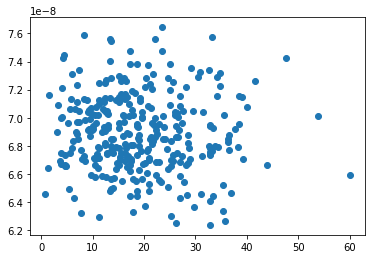

Epoch 2/2
31/31 [==============================] - 8s 221ms/step - loss: 123.2647 - NMSE: 123.2647 - NMAE: 112.7820 - NDOOMSE: 2576.0906 - NPCL: 54299.7642 - NBCE: 102.3753 - PAVG: 18.2488 - TAVG: 18.4090 - STD: 9.6763


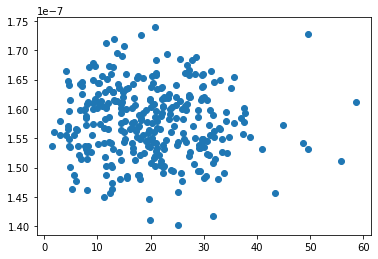

 14%|█▍        | 1/7 [00:39<03:54, 39.10s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'firstLayer': 'rawmask', 'firstLayerSize': 1000, 'learnEnding': False, 'learning_rate': 0.0001, 'los_scale': 1, 'loss': 'MSE', 'mobileNet_alpha': 1, 'mobileNet_pooling': 'avg', 'secondLayerSize': 500, 'sharedWeights': True}
Epoch 1/2
31/31 [==============================] - 15s 213ms/step - loss: 230.3149 - NMSE: 230.3149 - NMAE: 150.0991 - NDOOMSE: 670.1895 - NPCL: 9547.7292 - NBCE: 92.2125 - PAVG: 9.3994 - TAVG: 18.5755 - STD: 9.3775


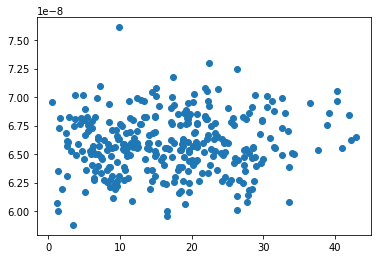

Epoch 2/2
31/31 [==============================] - 8s 215ms/step - loss: 127.3178 - NMSE: 127.3178 - NMAE: 113.1292 - NDOOMSE: 2076.0694 - NPCL: 28518.9630 - NBCE: 94.6084 - PAVG: 18.0929 - TAVG: 19.0819 - STD: 9.8980


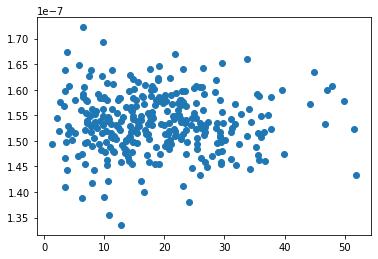

 29%|██▊       | 2/7 [01:15<03:11, 38.38s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'firstLayer': 'sobel', 'firstLayerSize': 1000, 'learnEnding': False, 'learning_rate': 0.0001, 'los_scale': 1, 'loss': 'MSE', 'mobileNet_alpha': 1, 'mobileNet_pooling': 'avg', 'secondLayerSize': 500, 'sharedWeights': True}
Epoch 1/2
31/31 [==============================] - 15s 205ms/step - loss: 213.0529 - NMSE: 213.0529 - NMAE: 144.3625 - NDOOMSE: 917.0915 - NPCL: 12981.7728 - NBCE: 102.4598 - PAVG: 8.7509 - TAVG: 17.8054 - STD: 9.3143


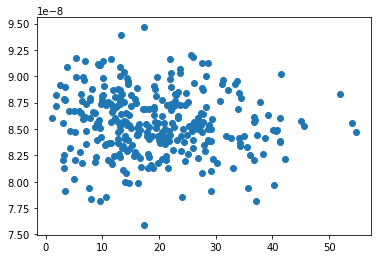

Epoch 2/2
31/31 [==============================] - 8s 225ms/step - loss: 115.3508 - NMSE: 115.3508 - NMAE: 108.0436 - NDOOMSE: 3412.5635 - NPCL: 99970.4352 - NBCE: 93.5880 - PAVG: 18.5531 - TAVG: 18.5844 - STD: 9.5443


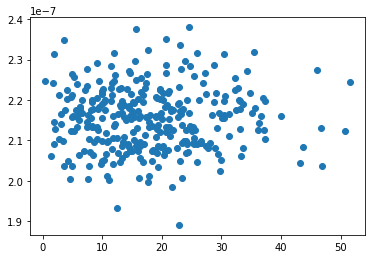

 43%|████▎     | 3/7 [01:53<02:33, 38.27s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'firstLayer': 'fixsobel', 'firstLayerSize': 1000, 'learnEnding': False, 'learning_rate': 0.0001, 'los_scale': 1, 'loss': 'MSE', 'mobileNet_alpha': 1, 'mobileNet_pooling': 'avg', 'secondLayerSize': 500, 'sharedWeights': True}
Epoch 1/2
31/31 [==============================] - 16s 232ms/step - loss: 221.4907 - NMSE: 221.4907 - NMAE: 145.2127 - NDOOMSE: 523.3039 - NPCL: 0.0000e+00 - NBCE: 94.2208 - PAVG: 9.1005 - TAVG: 18.3767 - STD: 9.3658


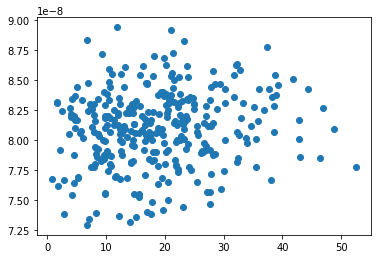

Epoch 2/2
31/31 [==============================] - 8s 232ms/step - loss: 114.4096 - NMSE: 114.4096 - NMAE: 106.8481 - NDOOMSE: 1367.8109 - NPCL: 16479.6431 - NBCE: 95.3038 - PAVG: 19.0051 - TAVG: 18.3440 - STD: 9.4858


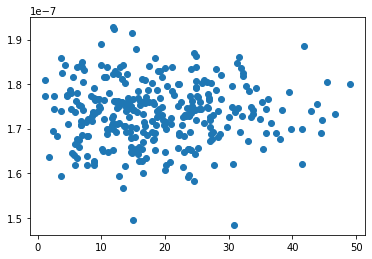

 57%|█████▋    | 4/7 [02:32<01:55, 38.42s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'firstLayer': 'PConv', 'firstLayerSize': 1000, 'learnEnding': False, 'learning_rate': 0.0001, 'los_scale': 1, 'loss': 'MSE', 'mobileNet_alpha': 1, 'mobileNet_pooling': 'avg', 'secondLayerSize': 500, 'sharedWeights': True}
Epoch 1/2
31/31 [==============================] - 16s 211ms/step - loss: 222.6884 - NMSE: 222.6884 - NMAE: 148.3188 - NDOOMSE: 454.7682 - NPCL: 6135.7990 - NBCE: 102.5434 - PAVG: 9.3317 - TAVG: 18.1130 - STD: 9.4330


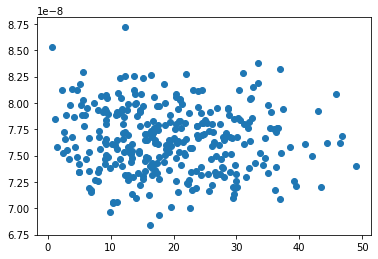

Epoch 2/2
31/31 [==============================] - 8s 222ms/step - loss: 122.4856 - NMSE: 122.4856 - NMAE: 111.1639 - NDOOMSE: 1810.2169 - NPCL: 32092.3931 - NBCE: 95.7530 - PAVG: 18.1354 - TAVG: 18.7924 - STD: 9.6480


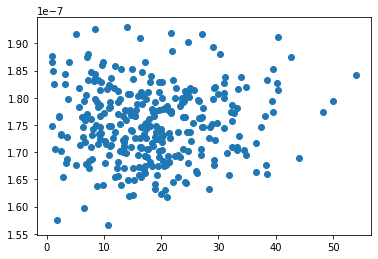

 71%|███████▏  | 5/7 [03:10<01:16, 38.25s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'firstLayer': 'SymConv', 'firstLayerSize': 1000, 'learnEnding': False, 'learning_rate': 0.0001, 'los_scale': 1, 'loss': 'MSE', 'mobileNet_alpha': 1, 'mobileNet_pooling': 'avg', 'secondLayerSize': 500, 'sharedWeights': True}
Epoch 1/2
31/31 [==============================] - 16s 215ms/step - loss: 260.5016 - NMSE: 260.5016 - NMAE: 159.3879 - NDOOMSE: 630.1090 - NPCL: 6795.0801 - NBCE: 86.9037 - PAVG: 8.3815 - TAVG: 19.0752 - STD: 9.5714


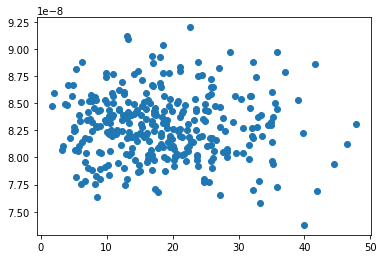

Epoch 2/2
31/31 [==============================] - 8s 222ms/step - loss: 110.5302 - NMSE: 110.5302 - NMAE: 106.6967 - NDOOMSE: 934.7996 - NPCL: 1738.3998 - NBCE: 94.7854 - PAVG: 19.1696 - TAVG: 18.5454 - STD: 9.4154


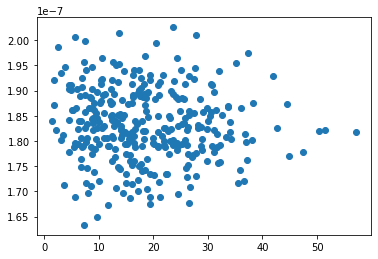

 86%|████████▌ | 6/7 [03:48<00:38, 38.17s/it]

{'activation': 'relu', 'batch_size': 32, 'dropout': 0.2, 'firstLayer': 'Conv', 'firstLayerSize': 1000, 'learnEnding': False, 'learning_rate': 0.0001, 'los_scale': 1, 'loss': 'MSE', 'mobileNet_alpha': 1, 'mobileNet_pooling': 'avg', 'secondLayerSize': 500, 'sharedWeights': True}
Epoch 1/2
31/31 [==============================] - 15s 211ms/step - loss: 258.2047 - NMSE: 258.2047 - NMAE: 160.0885 - NDOOMSE: 555.3120 - NPCL: 2547.9358 - NBCE: 85.1955 - PAVG: 9.0268 - TAVG: 19.1677 - STD: 9.4761


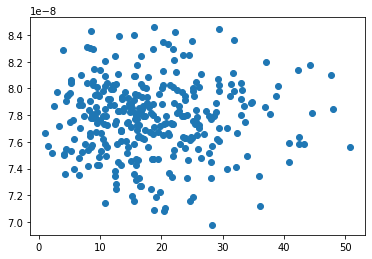

Epoch 2/2
31/31 [==============================] - 8s 223ms/step - loss: 120.3345 - NMSE: 120.3345 - NMAE: 110.6032 - NDOOMSE: 640.3352 - NPCL: 4812.1166 - NBCE: 94.1804 - PAVG: 18.3077 - TAVG: 18.8633 - STD: 9.7290


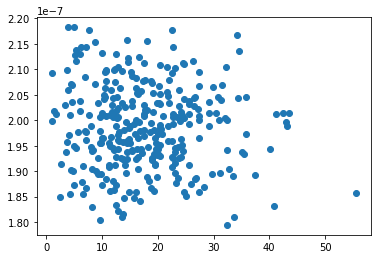

100%|██████████| 7/7 [04:25<00:00, 37.98s/it]


In [12]:
generator=deep_ga.PatchDataGenerator(10,height,batch_size=32,params=p)
fake_generator=deep_ga.PatchDataGenerator(10,height,batch_size=320,params=p)
(fake_a, fake_b), fake_out = fake_generator[0]

i=0
experiment_path = os.path.relpath(os.path.join(
    drive_folder, "talos_oxia_inputs"))

import shutil
if os.path.exists(experiment_path):
  shutil.rmtree(experiment_path)

scan_object = talos.Scan(
    x=[fake_a, fake_b], y=fake_out,
    params=hyperparams,
    model=talos_model,
    experiment_name=experiment_path,
    time_limit=(datetime.datetime.now() +
                datetime.timedelta(hours=40)).strftime("%Y-%m-%d %H:%M"),
    # reduction_method='correlation',
    # reduction_interval=10,
    # reduction_window=20,
    # reduction_threshold=0.2,
    # reduction_metric='NMSE',
    minimize_loss=True,
    save_weights=True,
    print_params=True,
    random_method='quantum'
)


In [13]:
import pickle


def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, protocol=2)


def project_object(obj, *attributes):
    out = {}
    for a in attributes:
        out[a] = getattr(obj, a)
    return out


pickle_path = os.path.join(
    experiment_path, datetime.datetime.now().strftime("%Y%m%d_%H%M.pickle"))
t = project_object(scan_object, 'params', 'saved_models',
                   'saved_weights', 'data', 'details', 'round_history')
save_object(t, pickle_path)


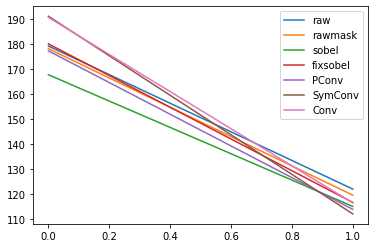

In [22]:
for history in scan_object.round_history:
  plt.plot(history["loss"])


plt.legend(scan_object.data["firstLayer"])



Copy this on the console to prevent termination:
```
function ClickConnect() {
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect, 60000)
```

Interesting resources: 
 - Hyperparameter optimization with talos
 - Tinyfying Neural Network with uTensor or TinyML

